<a href="https://colab.research.google.com/github/100jy/dacon_ts_forecasting/blob/main/%EC%8B%9C%EA%B3%84%EC%97%B4_%EC%98%88%EC%B8%A1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install torchcontrib

  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-cp36-none-any.whl size=7531 sha256=315bd41f31ef53604e7b205512e95b8e567234bf350c547c47c24e0f29d20c76
  Stored in directory: /root/.cache/pip/wheels/06/06/7b/a5f5920bbf4f12a2c927e438fac17d4cd9560f8336b00e9a99
Successfully built torchcontrib


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
import torch.optim.adam
from torchcontrib.optim import SWA
import datetime
import matplotlib.pyplot as plt 
from tqdm import tqdm

# feature 생성

In [7]:

train = pd.read_csv("./drive/MyDrive/데이콘/train.csv", encoding = 'euc-kr')

# 시간 관련 변수들
train['DateTime'] = pd.to_datetime(train.DateTime)
#일자
train['Date'] = train.DateTime.dt.date

# 요일 혹은 분기정보
train['DayOfWeek'] = (train.DateTime.dt.weekday)/6
train['DayOfMon'] = ((train.DateTime).dt.day)/31
train['Quarter'] = ((train.DateTime).dt.quarter)/4

train['Year'] = ((train.DateTime.dt.year) -2019)
train['Days'] = (train.DateTime.max() - train.DateTime).dt.days + 1


left = train.iloc[:,:5].groupby(train['Date']).sum().reset_index()
right = train.iloc[:,5:].groupby(train['Date']).mean().reset_index()
train  = pd.merge(left, right, on='Date')

def log_trans(x):
  return np.log(1+x)

train['Days'] = log_trans(train['Days'])


# ts feature 생성 
for target in ['사용자', '세션', '신규방문자', '페이지뷰']:
    train[f'{target}CumSum'] = train[target].cumsum()
    # log하고 rolling mean
    train[target] = log_trans(train[target])
    
    for k in [3,7,14,21]:
        train[f'{target}RollingMean{k}'] =  (train[target].rolling(k).mean())

    train[f'{target}RollingStd21'] =  (train[target].rolling(21).std().round(0))
    train[f'{target}DaysSince10000'] = (train[f'{target}CumSum'] > 10000) * 1
    train[f'{target}DaysSince100000'] = (train[f'{target}CumSum'] > 100000) * 1

    train[f'{target}RollingMeanDiff2w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean14'] + 1) - 1
    train[f'{target}RollingMeanDiff3w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean21'] + 1) - 1


    train[f'{target}CumSum'] = log_trans(train[target].cumsum())
    
    
train = train.dropna()

In [ ]:
train

,Date,사용자,세션,신규방문자,페이지뷰,DayOfWeek,DayOfMon,Quarter,Year,Days,사용자CumSum,사용자RollingMean3,사용자RollingMean7,사용자RollingMean14,사용자RollingMean21,사용자RollingStd21,사용자DaysSince10000,사용자DaysSince100000,사용자RollingMeanDiff2w,사용자RollingMeanDiff3w,세션CumSum,세션RollingMean3,세션RollingMean7,세션RollingMean14,세션RollingMean21,세션RollingStd21,세션DaysSince10000,세션DaysSince100000,세션RollingMeanDiff2w,세션RollingMeanDiff3w,신규방문자CumSum,신규방문자RollingMean3,신규방문자RollingMean7,신규방문자RollingMean14,신규방문자RollingMean21,신규방문자RollingStd21,신규방문자DaysSince10000,신규방문자DaysSince100000,신규방문자RollingMeanDiff2w,신규방문자RollingMeanDiff3w,페이지뷰CumSum,페이지뷰RollingMean3,페이지뷰RollingMean7,페이지뷰RollingMean14,페이지뷰RollingMean21,페이지뷰RollingStd21,페이지뷰DaysSince10000,페이지뷰DaysSince100000,페이지뷰RollingMeanDiff2w,페이지뷰RollingMeanDiff3w
20,2018-09-29,4.605170,4.564348,3.258097,5.937536,0.833333,0.935484,0.75,-1,6.650279,4.735195,4.869078,4.901977,5.216269,5.375507,0.0,0,0,-0.211428,-0.231124,4.724769,4.824457,4.854300,5.163014,5.319258,0.0,0,0,-0.212350,-0.231824,4.384408,3.522882,3.297626,3.665960,3.770989,0.0,0,0,-0.293259,-0.308817,5.032303,6.437932,6.569075,7.005833,7.251697,1.0,1,0,-0.179464,-0.203912
21,2018-09-30,4.804021,4.770685,4.110874,6.068426,1.000000,0.967742,0.75,-1,6.648985,4.776512,4.743158,4.861466,5.179898,5.335607,0.0,0,0,-0.213342,-0.232676,4.766226,4.704719,4.813506,5.126405,5.280374,0.0,0,0,-0.214302,-0.233564,4.434401,3.631777,3.369048,3.714309,3.761790,0.0,0,0,-0.285357,-0.292483,5.071129,6.163532,6.443156,6.918217,7.183030,1.0,1,0,-0.186287,-0.212620
22,2018-10-01,4.718499,4.709530,3.583519,6.016157,0.000000,0.032258,1.00,-1,6.647688,4.815497,4.709230,4.849248,5.102282,5.294596,0.0,0,0,-0.205338,-0.229617,4.805533,4.681521,4.817420,5.054676,5.242093,0.0,0,0,-0.204347,-0.228236,4.476031,3.650830,3.453017,3.666811,3.744279,0.0,0,0,-0.260091,-0.272172,5.108187,6.007373,6.373638,6.773971,7.105402,1.0,1,0,-0.180131,-0.213656
23,2018-10-02,4.634729,4.564348,3.332205,6.150603,0.166667,0.064516,1.00,-1,6.646391,4.852365,4.719083,4.836012,5.018252,5.239150,0.0,0,0,-0.196443,-0.224893,4.842209,4.681521,4.795398,4.970030,5.186120,0.0,0,0,-0.196755,-0.224813,4.513245,3.675532,3.532963,3.598364,3.708787,0.0,0,0,-0.231691,-0.249709,5.144705,6.078395,6.357524,6.649794,7.036364,1.0,1,0,-0.168929,-0.208905
24,2018-10-03,4.477337,4.442651,3.496508,5.953243,0.333333,0.096774,1.00,-1,6.645091,4.886735,4.610188,4.748832,4.945995,5.180590,0.0,0,0,-0.201339,-0.231654,4.876659,4.572177,4.708655,4.901780,5.128010,0.0,0,0,-0.202164,-0.231618,4.550861,3.470744,3.584536,3.588287,3.692971,0.0,0,0,-0.218764,-0.236190,5.178825,6.040001,6.214604,6.548356,6.945484,1.0,1,0,-0.176694,-0.217845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,2020-11-04,8.415603,8.405815,7.087574,11.632343,0.333333,0.129032,1.00,1,1.791759,8.545119,8.493688,8.150105,7.997219,7.911945,0.0,1,1,-0.094153,-0.085485,8.545642,8.480453,8.140212,7.982302,7.897867,0.0,1,1,-0.093750,-0.085150,8.312803,7.173000,6.724839,6.567518,6.526851,0.0,1,1,-0.111355,-0.106553,8.882520,11.751806,11.411049,11.201915,11.067752,0.0,1,1,-0.064815,-0.054418
788,2020-11-05,8.332308,8.303505,6.951772,11.541532,0.500000,0.161290,1.00,1,1.609438,8.546739,8.448526,8.157186,8.025890,7.943131,0.0,1,1,-0.096246,-0.087882,8.547254,8.428575,8.143469,8.009172,7.928125,0.0,1,1,-0.096091,-0.087886,8.314507,7.123032,6.742573,6.588043,6.556218,0.0,1,1,-0.111421,-0.107679,8.884120,11.699392,11.404360,11.236871,11.108657,0.0,1,1,-0.068033,-0.058165
789,2020-11-06,8.206311,8.182280,6.716595,11.385274,0.666667,0.193548,1.00,1,1.386294,8.548331,8.318074,8.174711,8.057857,7.969705,0.0,1,1,-0.097501,-0.088631,8.548841,8.297200,8.161402,8.041277,7.954937,0.0,1,1,-0.097318,-0.088614,8.316151,6.918647,6.762790,6.615423,6.582465,0.0,1,1,-0.111961,-0.108101,8.885697,11.519716,11.400896,11.272959,11.141020,0.0,1,1,-0.071056,-0.060961


In [59]:
def make_data(df, window_size=30):
  # in 180
  input_window = window_size
  # out 61 
  output_window = 61

  window_x = np.zeros((df.shape[0] - (input_window + output_window), input_window, df.shape[1]-1))
  window_y = np.zeros((df.shape[0] - (input_window + output_window), output_window, 4))

  for start in range(df.shape[0] - (input_window + output_window)):
      end = start + input_window    
      window_x[start,:, :] = df.iloc[start : end, 1: ].values
      window_y[start,:, :] = df.iloc[end   : end + output_window, 1: 5].values


  return window_x, window_y

In [69]:
class DatasetWindows(Dataset):
  def __init__(self, df, input_days):
    x, y = make_data(df, input_days)
    
    self.x = torch.tensor(x, dtype=torch.float32).cuda()
    self.y = torch.tensor(y, dtype=torch.float32).cuda()
    
  def __len__(self):
    return len(self.x)
    
  def __getitem__(self, idx):
    return self.x[idx,...], self.y[idx,...]

# model

In [63]:
# in 61 out 61일
# B x 61 x 75
# embedding
# B x 61 x 4
class SimpleLinear(nn.Module):
    def __init__(self, input_days, embedded_dim, hidden_size, num_layers, batch_out_p):
        super(SimpleLinear, self).__init__()

        self.embedding = nn.Sequential(nn.Linear(49, embedded_dim),
                                       nn.Dropout(batch_out_p),
                                       nn.ReLU())
        
        self.LSTM = nn.Sequential(nn.LSTM(input_size = input_days,
                            hidden_size = hidden_size,
                            num_layers=num_layers,
                            batch_first=True))
        
        self.last = nn.Sequential(nn.Linear(embedded_dim, 4))
    
    def forward(self, x_time):
        x_time = self.embedding(x_time)
        x_time = x_time.transpose(-2,-1)
        x_time,_ = self.LSTM(x_time)
        x_time = x_time[...,-61:]
        x_time = x_time.transpose(-2,-1)
        out_time = self.last(x_time)
        
        return out_time

In [71]:
class ModelManager():
  def __init__(self, model_name, embedded_dim, hidden_size, num_layers, batch_out_p, df, device='gpu', cv=50):
    super(ModelManager, self).__init__()
    self.cv = cv
    # CV 구현..
    self.models = []
    self.dataloders = []
    
    for i in range(cv):  
      days = [30, 60, 90, 120, 180, 360]
      input_days = days[i%6]
      model =  model_name(input_days, embedded_dim, hidden_size, num_layers, batch_out_p)
      if device == 'gpu':
        model =  model.cuda()
      self.models.append(model)

      cv_set = df
      dataset = DatasetWindows(cv_set, input_days)
      self.dataloders.append(DataLoader(dataset, batch_size=30,  num_workers=0, pin_memory=False,
                                        shuffle=True))
    
  def fit(self, num_epochs=500, lr=1e-2 ,log=False, val_set=None, train_set=None):
    
    def get_val_loss():
      val_loss = self.make_val_plot(val_set, train_set, get_loss=True)
      return val_loss

    for i in tqdm(range(self.cv)):  
      # Train model
      model = self.models[i]
      dataloader = self.dataloders[i]
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
      criterion = nn.MSELoss(reduction='mean')
      running_loss = 0

      for epoch in range(num_epochs):
          for idx,data in enumerate(dataloader):
              x, y = data
              train_pred = model(x)
              loss = criterion(train_pred, y)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              running_loss += loss.item()
          if epoch % 100 == 99:
            if log:
              if val_set.any().any():
                val_loss = get_val_loss()
                print(f"{epoch+1} Epochs train MSE: {running_loss/(100*idx):1.5f}, ", f"{epoch+1} Epochs val MSE: {val_loss:1.5f}")
              else: 
                print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}")
              running_loss = 0

  @staticmethod
  def inverse_log(x):
    # 32bit 사용시 단위문제 발생..
    return (np.exp(x)-1).astype(np.int64)

  def predict(self, df):

    last_observe = df.iloc[-input_days:,1:]
    inp_tensor = torch.tensor(last_observe.values, dtype=torch.float32).cuda()
    inp_tensor = inp_tensor.unsqueeze(0)

    model = self.models[0].eval()
    prediction = model(inp_tensor)
    self.models[0] = model.train()

    for i in range(1, self.cv): 
      model = self.models[i].eval()
      prediction += model(inp_tensor)
      self.models[i] = model.train()
    
    prediction /= self.cv
    return  self.inverse_log(prediction.cpu().detach().squeeze().numpy())

  def make_val_plot(self, val_df, train_df, get_loss=False):
    #predict
    pred = self.predict(train_df)
    label = self.inverse_log(val_df)

    def dacon_rmse(true, pred):  
      w0 = 1095.214646
      w1 = 1086.728535
      w2 = 268.070707
      w3 = 24236.194444

      score = (np.sqrt(np.mean(np.square(true[:,0] - pred[:,0]))) / w0 + 
               np.sqrt(np.mean(np.square(true[:,1] - pred[:,1]))) / w1 + 
               np.sqrt(np.mean(np.square(true[:,2] - pred[:,2]))) / w2 + 
               np.sqrt(np.mean(np.square(true[:,3] - pred[:,3]))) / w3  )
      return score

    if get_loss:
      return dacon_rmse(label.values, pred)

    for idx, key in enumerate(val_df.columns):
      plt.plot(figsize=(20,10))
      plt.plot(label.index,pred[:,idx])
      plt.plot(label[key])
      plt.legend(['predict', 'label'])
      plt.show()
      
    loss = dacon_rmse(label.iloc[:,:4].values, pred)
    print('RMSE : ' + str(loss))

In [72]:
# train val split
train_whole = train
train_split = train[:-61]
val = train.iloc[-61:, 1:5]

embedded_dim = 256
hidden_size = 256
num_layers = 1
batch_out_p = 0.3

simple = ModelManager(SimpleLinear, embedded_dim, hidden_size, num_layers, batch_out_p, train_split, cv=6)
simple.fit(num_epochs=1000, lr=1e-3, log=True, val_set=val, train_set=train_split)









  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

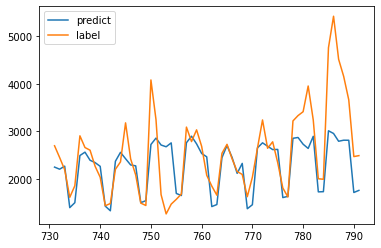

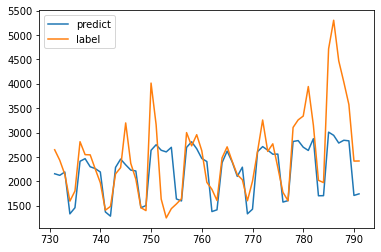

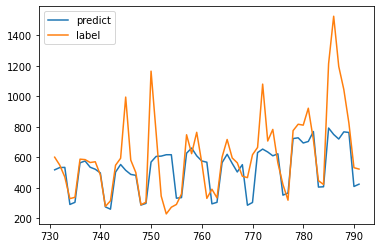

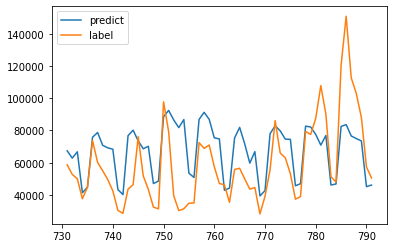

RMSE : 2.937328273809758


In [53]:
simple.make_val_plot(val, train_split)

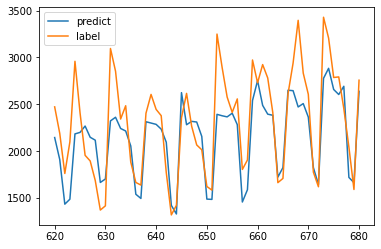

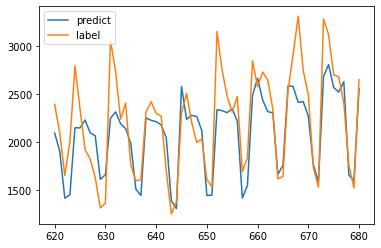

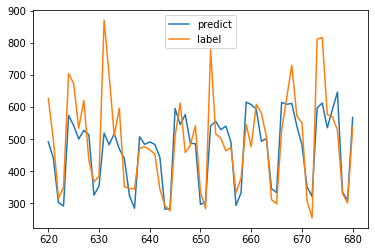

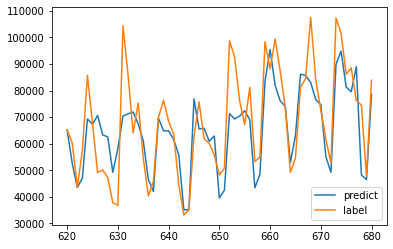

RMSE : 1.4564679700178707


In [ ]:
simple.make_val_plot( train_split.iloc[600:600 + 61, 1:5], train_split[:600])

In [ ]:
predictor = ModelManager(SimpleLinear, train_whole, cv=1)
predictor.fit(num_epochs=1500, lr=1e-3, log=False)





























  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))




























100%|██████████| 1/1 [01:50<00:00, 110.01s/it]


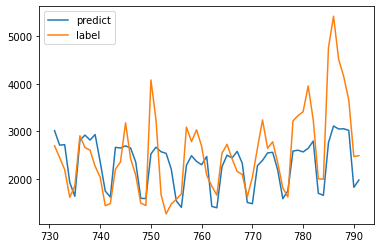

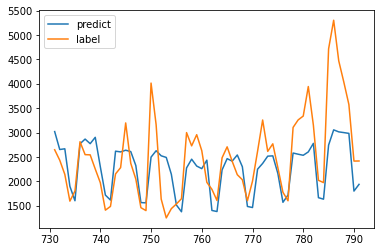

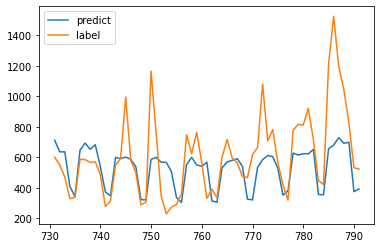

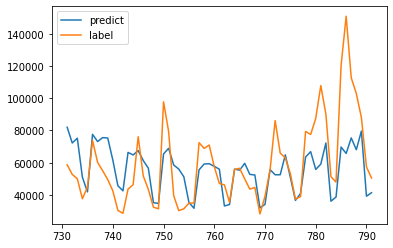

RMSE : 2.956989941812016


In [ ]:
predictor.make_val_plot(val, train_split)

In [ ]:
submission = pd.read_csv("./drive/MyDrive/데이콘/submission.csv", encoding = 'euc-kr') 
submission.iloc[:,1:] = predictor.predict(train_whole)
submission.to_csv('submission.csv', index = False, encoding = 'euc-kr')
print(submission)
print('saved result')

      DateTime   사용자    세션  신규방문자   페이지뷰
0   2020-11-09  3080  3089    729  83978
1   2020-11-10  2771  2722    651  74454
2   2020-11-11  2833  2792    666  79238
3   2020-11-12  2794  2741    636  75315
4   2020-11-13  2510  2468    569  66778
..         ...   ...   ...    ...    ...
56  2021-01-04  3040  3012    726  75299
57  2021-01-05  3033  2983    688  67744
58  2021-01-06  2810  2634    655  66581
59  2021-01-07  3005  2974    683  67544
60  2021-01-08  3065  3017    666  66842

[61 rows x 5 columns]
saved result
